In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import os

In [3]:
!pip install keras-unet

In [4]:
import keras
from keras_unet.models import custom_unet

2023-04-07 11:53:57.287943: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
/home/kunal.jain001/miniconda3/envs/O/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


-----------------------------------------
keras-unet init: TF version is >= 2.0.0 - using `tf.keras` instead of `Keras`
-----------------------------------------


In [5]:
NPYPATH = '/raid/mpsych/RISTERLAB/fly_segmentation_experiments/data_dir/test2/pre_processing/npy/'
MODELPATH = '/raid/mpsych/RISTERLAB/fly_segmentation_experiments/classified_images/models/04-07/'
images_file = os.path.join(NPYPATH, 'original.npy')
labels_file = os.path.join(NPYPATH, 'mask.npy')

In [6]:
images = np.load(images_file)
labels = np.load(labels_file)

In [7]:
images.shape

(1812, 512, 512)

In [8]:
labels.shape

(1812, 512, 512)

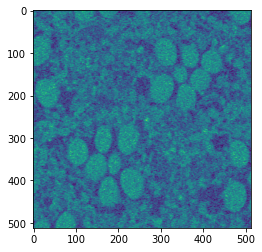

In [9]:
imshow(images[1000])

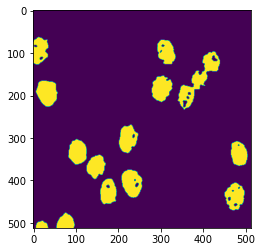

In [10]:
imshow(labels[1000])

In [11]:
images = np.expand_dims(images, axis=3)
labels = np.expand_dims(labels, axis=3)

In [12]:
random_indices = np.random.choice(1812, 400)

In [13]:
training_images = np.empty([400, 512, 512, 1])
training_labels = np.empty([4400, 512, 512, 1])
z = 0

for i in random_indices:
    training_images[z] = images[i]
    training_labels[z] = labels[i]
    z = z + 1

In [14]:
training_images.shape

(400, 512, 512, 1)

In [15]:
training_images = training_images.astype(np.float64)
training_labels = training_labels.astype(np.float64)

In [16]:
p = np.random.permutation(len(training_images))

In [17]:
training_images = training_images[p]
training_labels = training_labels[p]

In [18]:
import tensorflow as tf

In [19]:
all_images = []
all_labels = []

for i in range(training_images.shape[0]):
    training_images[i] = (training_images[i] - training_images[i].min()) / (training_images[i].max() - training_images[i].min()) # normalize individually
    
    mask = training_labels[i]
    image = training_images[i]
    
    all_images.append(image)
    all_labels.append(mask)

    image1 = tf.image.flip_left_right(image)
    mask1 = tf.image.flip_left_right(mask)
    
    all_images.append(image1)
    all_labels.append(mask1)
    

    image2 = tf.image.flip_up_down(image)
    mask2 = tf.image.flip_up_down(mask)
    
    all_images.append(image2)
    all_labels.append(mask2)

    image3 = tf.image.rot90(image)
    mask3 = tf.image.rot90(mask)
    
    all_images.append(image3)
    all_labels.append(mask3)

2023-04-07 11:54:02.755884: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2023-04-07 11:54:03.104431: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:87:00.0 name: A100-SXM4-40GB computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 39.59GiB deviceMemoryBandwidth: 1.41TiB/s
2023-04-07 11:54:03.109740: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 1 with properties: 
pciBusID: 0000:90:00.0 name: A100-SXM4-40GB computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 39.59GiB deviceMemoryBandwidth: 1.41TiB/s
2023-04-07 11:54:03.109760: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2023-04-07 11:54:03.135815: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2023-04-07 

In [20]:
all_images = np.array(all_images).astype(np.float64)
all_labels = np.array(all_labels).astype(np.float64)

In [21]:
all_images.shape

(1600, 512, 512, 1)

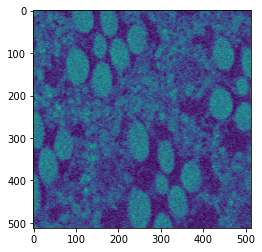

In [22]:
imshow(all_images[100])

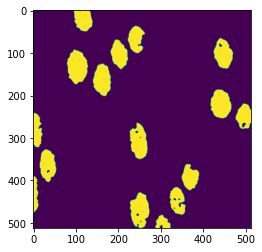

In [23]:
imshow(all_labels[100])

In [24]:
X_train = all_images[0:1200]
y_train = all_labels[0:1200]
X_val = all_images[1200:1400]
y_val = all_labels[1200:1400]
X_test = all_images[1400:]
y_test = all_labels[1400:]

In [ ]:
import keras.optimizers
from keras_unet.metrics import iou, iou_thresholded
from keras_unet.losses import jaccard_distance
from keras.callbacks import ModelCheckpoint

model = custom_unet(
    input_shape=(512, 512, 1),
    use_batch_norm=False,
    num_classes=1,
    filters=32,
    dropout=0.5,
    output_activation='sigmoid')

filepath = (os.path.join(MODELPATH, '04-06-32-500-{epoch:02d}-{val_loss:.2f}-{loss:.2f}-{accuracy:.2f}.hdf5'))

checkpoint = ModelCheckpoint(filepath,
                             monitor='val_loss', 
                             verbose=1,
                             save_best_only=False,
                             mode='auto', 
                             period=1)

opt = keras.optimizer_v1.Adam(lr=0.01)

model.compile(optimizer = 'Adam',    
              loss='binary_crossentropy', 
              metrics=[iou, iou_thresholded, 'accuracy'])

history = model.fit(X_train, 
                    y_train, 
                    32, 
                    epochs=500,
                    validation_data=(X_val, y_val), 
                    verbose=1,
                    callbacks=[checkpoint])

Epoch 1/500
38/38 [==============================] - 14s 333ms/step - loss: 0.4506 - iou: 0.0518 - iou_thresholded: 0.0035 - accuracy: 0.8685 - val_loss: 0.4362 - val_iou: 0.0867 - val_iou_thresholded: 1.7399e-06 - val_accuracy: 0.8976

Epoch 00001: saving model to /raid/mpsych/RISTERLAB/fly_segmentation_experiments/classified_images/models/04-07/04-06-32-500-01-0.44-0.45-0.87.hdf5
Epoch 2/500
38/38 [==============================] - 12s 323ms/step - loss: 0.3427 - iou: 0.0836 - iou_thresholded: 1.1239e-06 - accuracy: 0.8878 - val_loss: 0.3271 - val_iou: 0.1178 - val_iou_thresholded: 1.7399e-06 - val_accuracy: 0.8976

Epoch 00002: saving model to /raid/mpsych/RISTERLAB/fly_segmentation_experiments/classified_images/models/04-07/04-06-32-500-02-0.33-0.34-0.89.hdf5
Epoch 3/500
38/38 [==============================] - 12s 322ms/step - loss: 0.3082 - iou: 0.1135 - iou_thresholded: 6.7639e-04 - accuracy: 0.8879 - val_loss: 0.2214 - val_iou: 0.1571 - val_iou_thresholded: 9.3913e-05 - val_acc


Epoch 00043: saving model to /raid/mpsych/RISTERLAB/fly_segmentation_experiments/classified_images/models/04-07/04-06-32-500-43-0.09-0.04-0.98.hdf5
Epoch 44/500
38/38 [==============================] - 12s 325ms/step - loss: 0.0399 - iou: 0.8053 - iou_thresholded: 0.8610 - accuracy: 0.9832 - val_loss: 0.0917 - val_iou: 0.6380 - val_iou_thresholded: 0.6777 - val_accuracy: 0.9665

Epoch 00044: saving model to /raid/mpsych/RISTERLAB/fly_segmentation_experiments/classified_images/models/04-07/04-06-32-500-44-0.09-0.04-0.98.hdf5
Epoch 45/500
38/38 [==============================] - 13s 331ms/step - loss: 0.0385 - iou: 0.8103 - iou_thresholded: 0.8658 - accuracy: 0.9838 - val_loss: 0.0793 - val_iou: 0.6715 - val_iou_thresholded: 0.7116 - val_accuracy: 0.9696

Epoch 00045: saving model to /raid/mpsych/RISTERLAB/fly_segmentation_experiments/classified_images/models/04-07/04-06-32-500-45-0.08-0.04-0.98.hdf5
Epoch 46/500
38/38 [==============================] - 12s 323ms/step - loss: 0.0373 - i


Epoch 00086: saving model to /raid/mpsych/RISTERLAB/fly_segmentation_experiments/classified_images/models/04-07/04-06-32-500-86-0.08-0.02-0.99.hdf5
Epoch 87/500
38/38 [==============================] - 12s 326ms/step - loss: 0.0192 - iou: 0.9014 - iou_thresholded: 0.9308 - accuracy: 0.9920 - val_loss: 0.0724 - val_iou: 0.7644 - val_iou_thresholded: 0.7971 - val_accuracy: 0.9774

Epoch 00087: saving model to /raid/mpsych/RISTERLAB/fly_segmentation_experiments/classified_images/models/04-07/04-06-32-500-87-0.07-0.02-0.99.hdf5
Epoch 88/500
38/38 [==============================] - 12s 326ms/step - loss: 0.0197 - iou: 0.9002 - iou_thresholded: 0.9299 - accuracy: 0.9918 - val_loss: 0.0678 - val_iou: 0.7900 - val_iou_thresholded: 0.8177 - val_accuracy: 0.9796

Epoch 00088: saving model to /raid/mpsych/RISTERLAB/fly_segmentation_experiments/classified_images/models/04-07/04-06-32-500-88-0.07-0.02-0.99.hdf5
Epoch 89/500
38/38 [==============================] - 13s 334ms/step - loss: 0.0194 - i

38/38 [==============================] - 13s 331ms/step - loss: 0.0155 - iou: 0.9196 - iou_thresholded: 0.9437 - accuracy: 0.9935 - val_loss: 0.0708 - val_iou: 0.7946 - val_iou_thresholded: 0.8187 - val_accuracy: 0.9796

Epoch 00108: saving model to /raid/mpsych/RISTERLAB/fly_segmentation_experiments/classified_images/models/04-07/04-06-32-500-108-0.07-0.02-0.99.hdf5
Epoch 109/500
38/38 [==============================] - 12s 325ms/step - loss: 0.0162 - iou: 0.9175 - iou_thresholded: 0.9418 - accuracy: 0.9933 - val_loss: 0.0667 - val_iou: 0.7649 - val_iou_thresholded: 0.8007 - val_accuracy: 0.9778

Epoch 00109: saving model to /raid/mpsych/RISTERLAB/fly_segmentation_experiments/classified_images/models/04-07/04-06-32-500-109-0.07-0.02-0.99.hdf5
Epoch 110/500
38/38 [==============================] - 12s 329ms/step - loss: 0.0178 - iou: 0.9090 - iou_thresholded: 0.9364 - accuracy: 0.9926 - val_loss: 0.0760 - val_iou: 0.7754 - val_iou_thresholded: 0.8022 - val_accuracy: 0.9782

Epoch 00110


Epoch 00129: saving model to /raid/mpsych/RISTERLAB/fly_segmentation_experiments/classified_images/models/04-07/04-06-32-500-129-0.07-0.01-0.99.hdf5
Epoch 130/500
38/38 [==============================] - 12s 325ms/step - loss: 0.0136 - iou: 0.9294 - iou_thresholded: 0.9505 - accuracy: 0.9943 - val_loss: 0.0749 - val_iou: 0.7924 - val_iou_thresholded: 0.8116 - val_accuracy: 0.9790

Epoch 00130: saving model to /raid/mpsych/RISTERLAB/fly_segmentation_experiments/classified_images/models/04-07/04-06-32-500-130-0.07-0.01-0.99.hdf5
Epoch 131/500
33/38 [=========================>....] - ETA: 1s - loss: 0.0136 - iou: 0.9291 - iou_thresholded: 0.9504 - accuracy: 0.9943

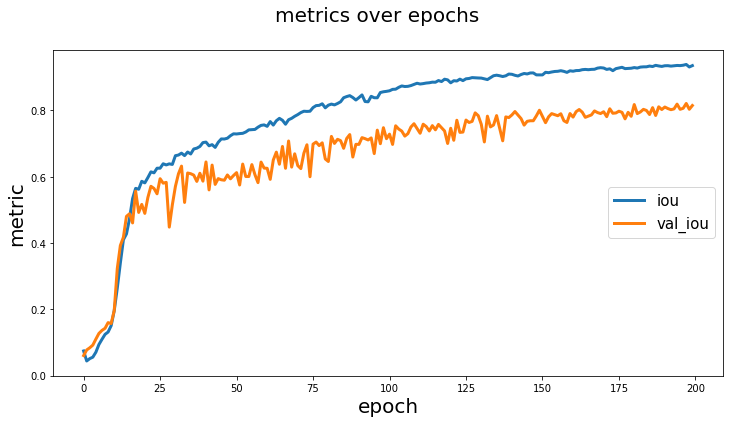

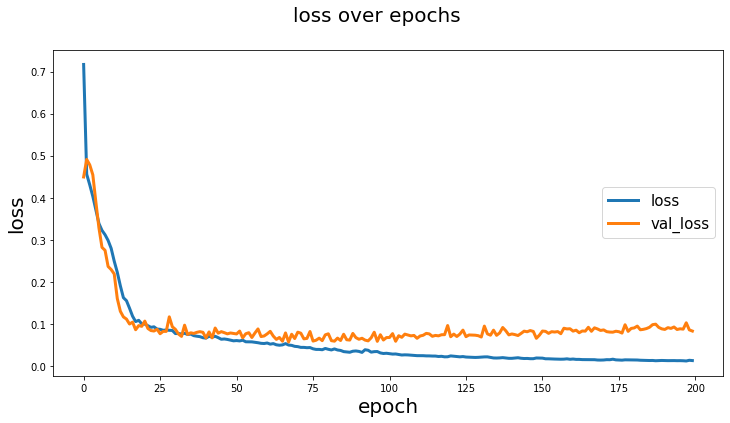

In [51]:
from keras_unet.utils import plot_segm_history

plot_segm_history(history)

In [27]:
y_pred = model.predict(X_test)

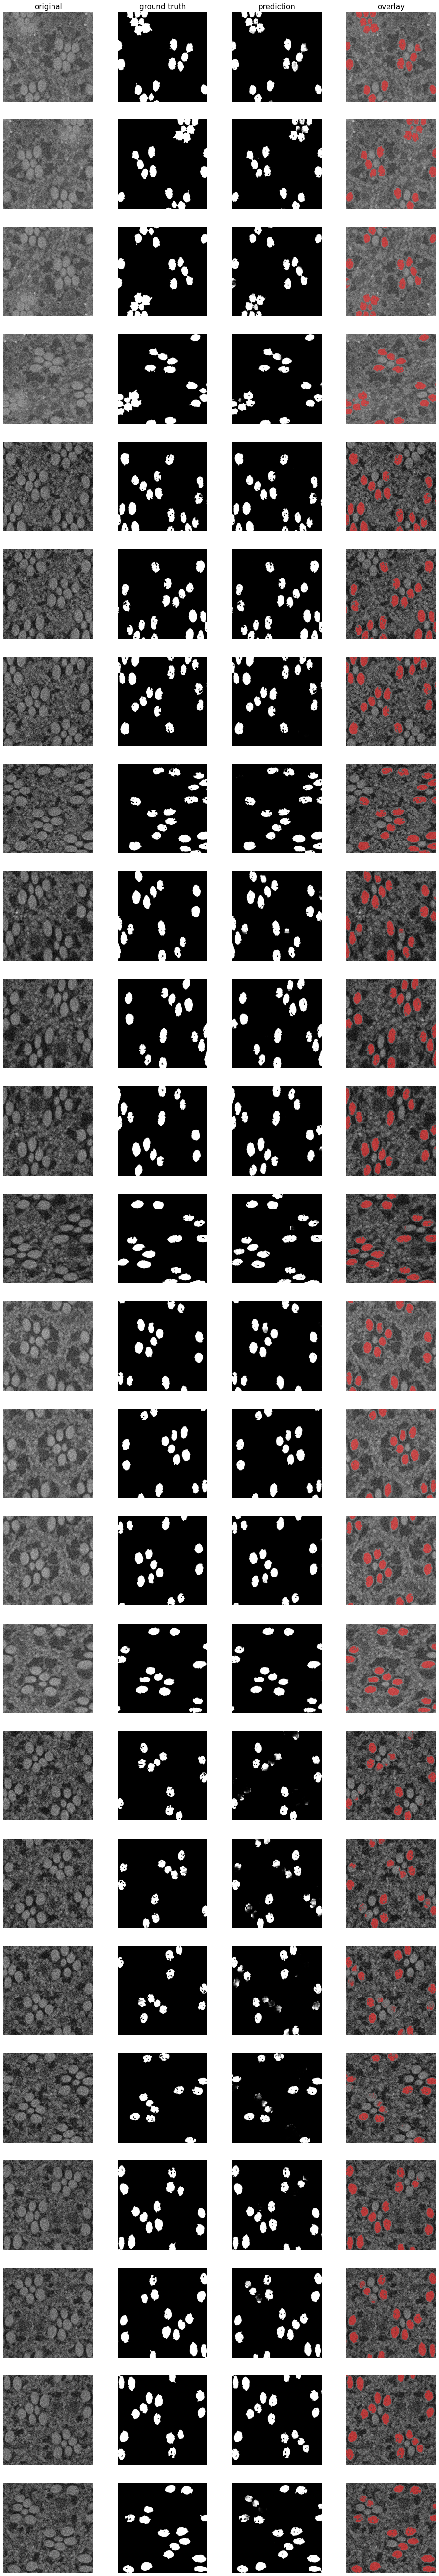

In [28]:
from keras_unet.utils import plot_imgs

plot_imgs(org_imgs=X_test, mask_imgs=y_test, pred_imgs=y_pred, nm_img_to_plot=24)